# You can skip this part and read it directly from the csv file

### Step 1A: calculate one possible realisation of actual storm surge levels at Rotterdam, for 4 different scenarios of SLR 
Each time you run you get another possible realisation of storm surge levels

Text(0, 0.5, 'Storm surge height (m)')

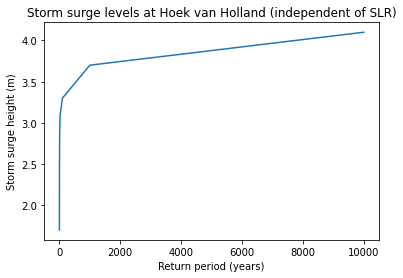

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from classes import SurgeSeries
import os
import csv
from math import exp, log

#STORM SURGE LEVELS AT HOEK VAN HOLLAND (ASSUMED TO BE INDEPENDENT OF SEA LEVEL RISE)
#Very roughly taken from Sterl et al. (2009)
RP = [1/5,  1/2,1 ,  2,  5,10,25  ,100,1000,10000]
surge = [1.7,2  ,2.2 ,2.4,2.7,2.9,3.1,3.3,3.7 ,4.1]
plt.plot(RP,surge)
plt.title('Storm surge levels at Hoek van Holland (independent of SLR)')
plt.xlabel('Return period (years)')
plt.ylabel('Storm surge height (m)')

In [52]:
#FOR NOW: ASSUME THAT ONE STORM PER YEAR WILL OCCUR
startyear = 2021
endyear = 2120
#APPROXIMATION OF THE GUMBEL PLOT OF Sterl et al. (2009) 
#"An ensemble study of extreme storm surge related water levels in the North Sea in a changing climate"
mu = 2.33
beta = 0.234
surges_t = np.random.gumbel(mu,beta,size=100) #calculates a storm surge level (m) for each year

### Gumbel equation
# $ F(x,\mu,\beta) = exp(-e^{(\mu-x)/\beta}) $

In [92]:
mu = 2.33
beta = 0.234

def Gumbel(x,mu,beta):
    "Returns the cumulative probability that X <= xp"
    return exp(-1* exp((mu-x)/beta))

def Gumbel_RP(x,mu,beta):
    return 1/(1-Gumbel(x,mu,beta))

def Gumbel_inverse(RP,mu,beta):
    "Returns the water level h (m) for a Gumbel distributed PDF"
    waterlevel = mu - beta * log(-1 * log((RP-1)/RP))
    return waterlevel

In [98]:
RP(3,mu,beta)

18.023088448847233

Wat moet een gebiedsobject doen?
Op tijdstip i:
 - bepaal zeespiegelstijging op i
     - zorgen dat dat in het model zit
 - bepaal uit de Gumbel: de storm surge level for de RP 10, 20, 50, 100, 200, 500
 - bepaal de totale waterhoogte op deze RPs
 - bereken de schades voor deze RPs
 - bepaal de return period van de huidige flood protection
 - berekenen de EAD

In [93]:
Gumbel_inverse(10,mu,beta)

2.8565859545911123

In [86]:
RP(0,mu,beta)

1.0

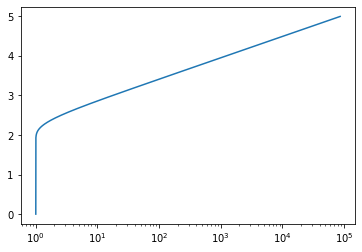

In [94]:
x = np.arange(0,5,0.01)
x
plt.plot([RP(x,mu,beta) for x in x],x)
plt.xscale('log')

In [23]:
#SLR scenarios
year = [2000,2020,2050,2075,2100]
A =    [0,   0.1 , 0.2, 0.3, 0.4] #Haasnoot et al. 2020, lower part of blue shaded area
B =    [0,   0.1 ,0.25,0.45, 1.0] #Middle of RCP4.5
C =    [0,   0.1 , 0.3,0.7 , 1.8] #Middle of RCP8.5
D =    [0,   0.15, 0.4, 1.0 ,3.0] #Max of RCP8.5   

#determine coefficients of paraboles plotted through these functions
A_p = np.polyfit(year,A,2) #returns the coefficient of the paraboles (highest first)
B_p = np.polyfit(year,B,2)
C_p = np.polyfit(year,C,2)
D_p = np.polyfit(year,D,2)

time = np.arange(2021,2121) #create list from 2021 to 2120

#CREATE TIME SERIES FOR SEA LEVEL RISE (IMITATE THOSE IN HAASNOOT ET AL 2020)
A_t = [(lambda x: A_p[2]+A_p[1]*x+A_p[0]*x**2)(x) for x in time]
B_t = [(lambda x: B_p[2]+B_p[1]*x+B_p[0]*x**2)(x) for x in time]
C_t = [(lambda x: C_p[2]+C_p[1]*x+C_p[0]*x**2)(x) for x in time]
D_t = [(lambda x: D_p[2]+D_p[1]*x+D_p[0]*x**2)(x) for x in time]

In [24]:
#Sum the storm surge levels and the SLR scenarios
levels_A_t = surges_t+A_t
levels_B_t = surges_t+B_t
levels_C_t = surges_t+C_t
levels_D_t = surges_t+D_t

#CALCULATE THE RPS (what would be the return period of the future floods for statistics of the current situation)
#WILL PROBABLY NO LONGER BE USED IN THE MODEL, BUT NICE TO KEEP FOR NOW
RPs_A_t = np.interp(levels_A_t,surge,RP)
RPs_B_t = np.interp(levels_B_t,surge,RP)
RPs_C_t = np.interp(levels_C_t,surge,RP)
RPs_D_t = np.interp(levels_D_t,surge,RP)

Text(0.5, 1.0, 'Scenario D')

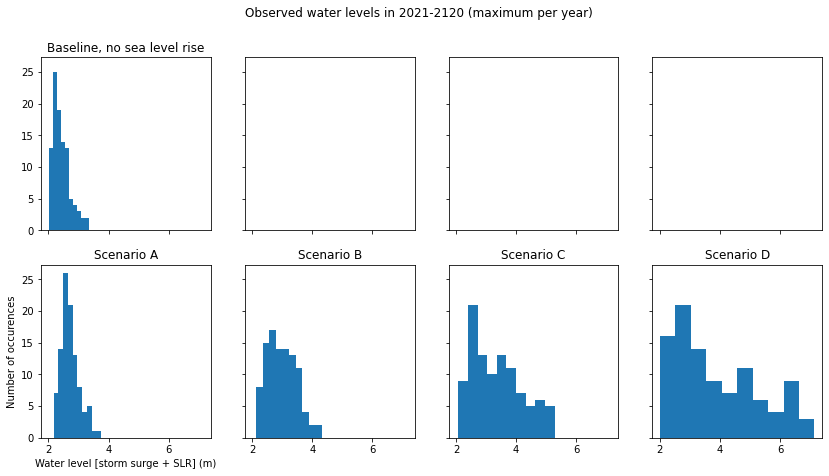

In [25]:
### PLOT THE HISTOGRAMS OF THE DIFFERENT RETURN PERIODS
figure, axes = plt.subplots(nrows=2,ncols=4,sharey=True,sharex=True,figsize=(14,7))
axes[0,0].hist(surges_t)
axes[1,0].hist(levels_A_t)
axes[1,1].hist(levels_B_t)
axes[1,2].hist(levels_C_t)
axes[1,3].hist(levels_D_t)
figure.suptitle('Observed water levels in 2021-2120 (maximum per year)')
axes[0,0].set_title('Baseline, no sea level rise')
axes[1,0].set_xlabel('Water level [storm surge + SLR] (m)')
axes[1,0].set_ylabel('Number of occurences')
axes[1,0].set_title('Scenario A')
axes[1,1].set_title('Scenario B')
axes[1,2].set_title('Scenario C')
axes[1,3].set_title('Scenario D')

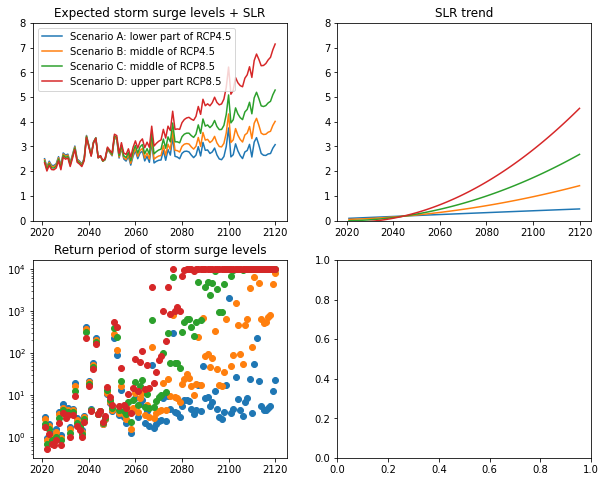

In [26]:
#Plot as a time series

fig, axes = plt.subplots(nrows=2,ncols=2,sharey=False,figsize=(10,8))
#fig = plt.figure()
axes[0,0].plot(time,levels_A_t,
             time,levels_B_t,
             time,levels_C_t,
             time,levels_D_t)
axes[0,0].legend(labels=[
    'Scenario A: lower part of RCP4.5',
    'Scenario B: middle of RCP4.5',   
    'Scenario C: middle of RCP8.5',   
    'Scenario D: upper part RCP8.5',
])
axes[0,0].set_title('Expected storm surge levels + SLR')
axes[0,1].set_title('SLR trend')
axes[1,0].set_title('Return period of storm surge levels')
axes[0,1].plot(time,A_t,time,B_t,time,C_t,time,D_t)

axes[0,0].set_ylim(0,8)
axes[0,1].set_ylim(0,8)

axes[1,0].scatter(time,RPs_A_t)
axes[1,0].scatter(time,RPs_B_t)
axes[1,0].scatter(time,RPs_C_t)
axes[1,0].scatter(time,RPs_D_t)
axes[1,0].set_yscale('log')

In [27]:
# Save the above series to the folder SurgeSeries so we can quickly reload
#SurgeSeries(None,None,levels_D_t,time).to_csv('D.csv')

In [31]:
def to_csv(time,trend,filename):
    "Write to a csv file (weakness: does not save the metadata yet)"
    zipped = list(zip(time,trend)) #zip the two lists
    with open(os.path.join("SurgeSeries",filename), "w",newline='') as f:
        writer = csv.writer(f)
        for row in zipped:
            writer.writerow(row)

to_csv(time,D_t,"D_trend.csv")